In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from cvt_utils import SpaceIterMesh
from plot_utils import display_plots, plot_cell_size_and_density, plot_seeds_and_cells, plot_bound_paths, display_animation

plt.style.use("dark_background")
np.random.seed(21)

# Problem definition
x_min = 0.0
x_max = 1.0
n_cells = 60
# n_cells = 100
# n_iters = 300
# n_iters = 2_000
# n_iters = 7_000
n_iters = 15000
# n_iters = 30000

mesh = SpaceIterMesh(x_min, x_max, n_cells, n_iters)
mesh.cell_size = lambda x: np.ones_like(x) * 0.1 # type: ignore
# mesh.cell_size = lambda x: np.exp(2*x)
# mesh.cell_size = lambda x: 1.0 + 0.5 * np.sin(2 * np.pi * x)

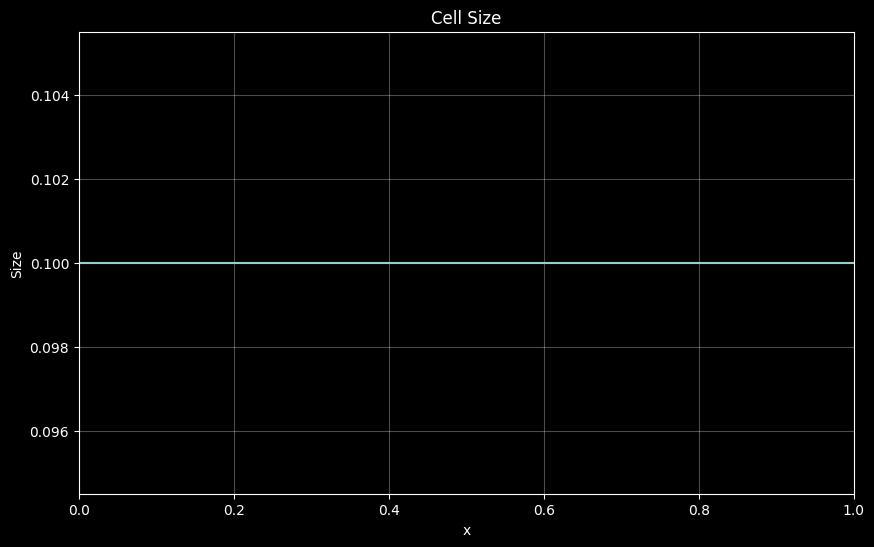

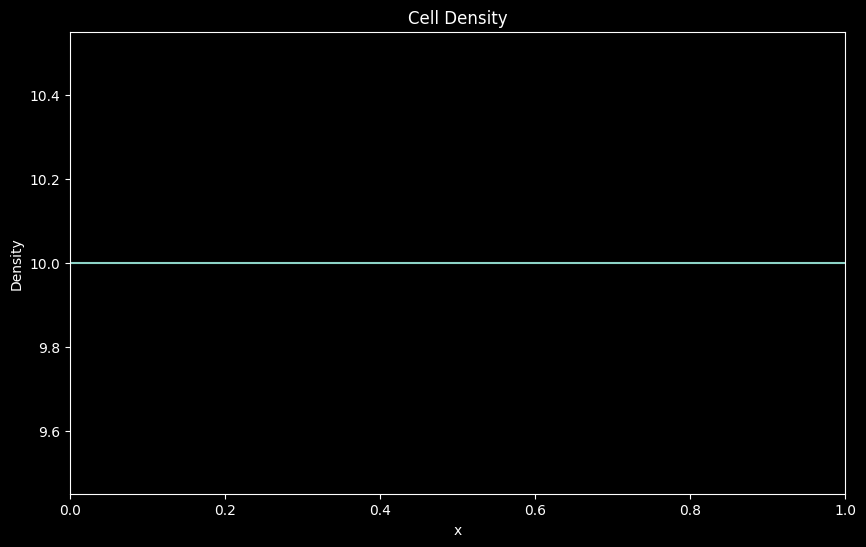

In [2]:
plot_cell_size_and_density(mesh)

### Iterations

In [3]:
mesh.set_initial_conditions()
mesh.set_boundary_conditions()

for iter in range(n_iters):
    mesh.update_cell_bounds(iter)
    mesh.update_cell_masses(iter)
    mesh.update_cell_moments(iter)
    mesh.update_cell_centroids(iter)
    if iter < n_iters - 1:
        mesh.update_cell_seeds(iter)

In [4]:
html = display_animation(mesh, duration=4.0, fps=60)
html

Duration: 4.0s
fps: 60
# of frames: 240
Interval: 16ms


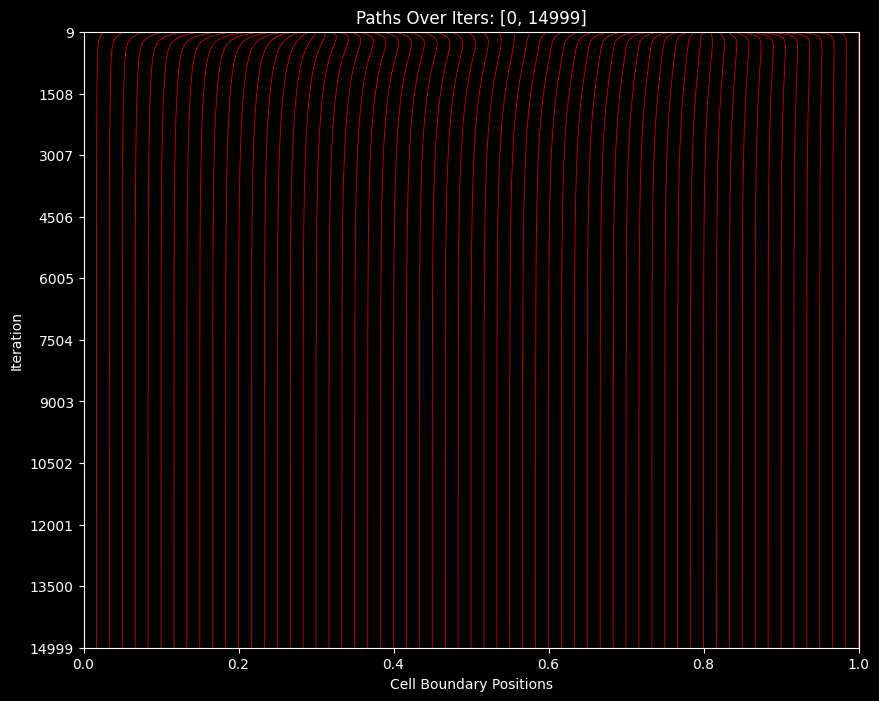

In [5]:
plot_bound_paths(mesh, 0, n_iters - 1)

### Errors

In [6]:
analytical = np.linspace(x_min, x_max, n_cells + 1)
min_errors = np.zeros(n_iters)
max_errors = np.zeros(n_iters)
rms_errors = np.zeros(n_iters)

for iter in range(n_iters):
    errors = mesh.bound_matrix[iter, :] - analytical
    min_errors[iter] = np.min(np.abs(errors))
    max_errors[iter] = np.max(np.abs(errors))
    rms_errors[iter] = np.sqrt(np.mean(errors**2))

In [7]:
from plot_utils import plot_errors

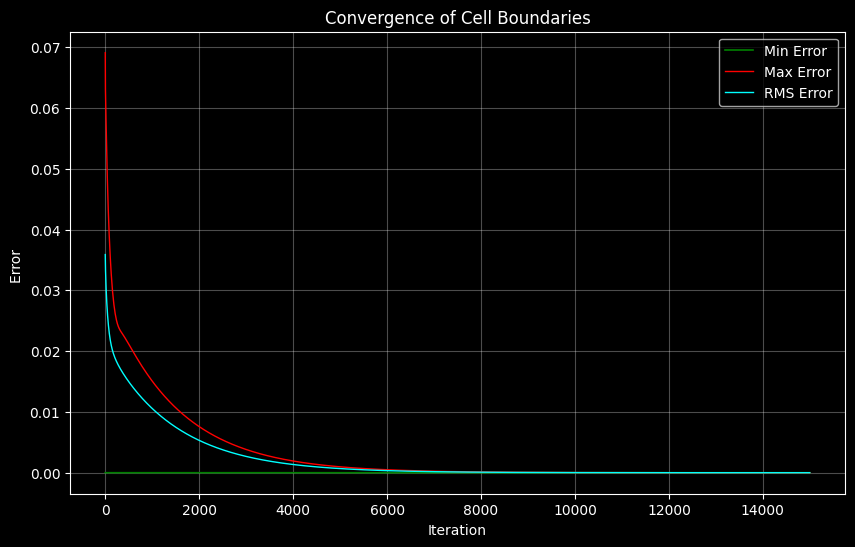

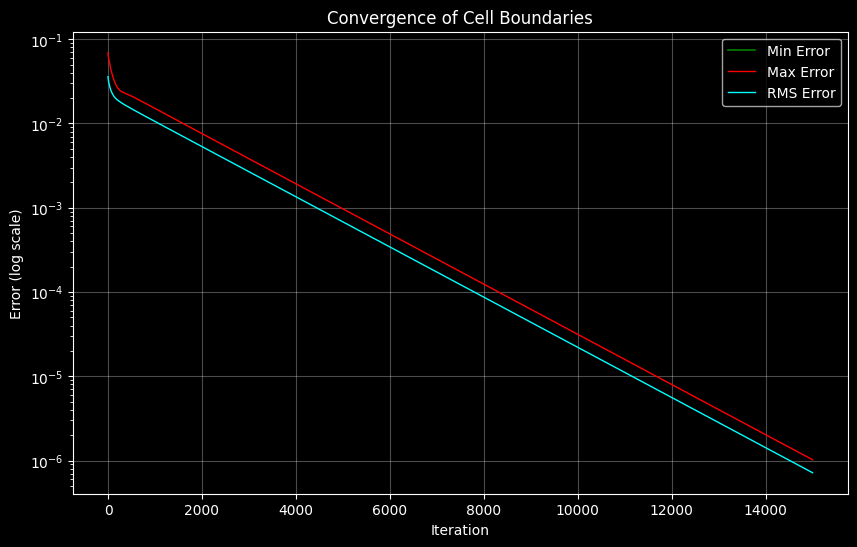

In [8]:
plot_errors(min_errors, max_errors, rms_errors, logscale=False)
plot_errors(min_errors, max_errors, rms_errors, logscale=True)

### Convergence

Observed order of convergence q ≈ 0.99998


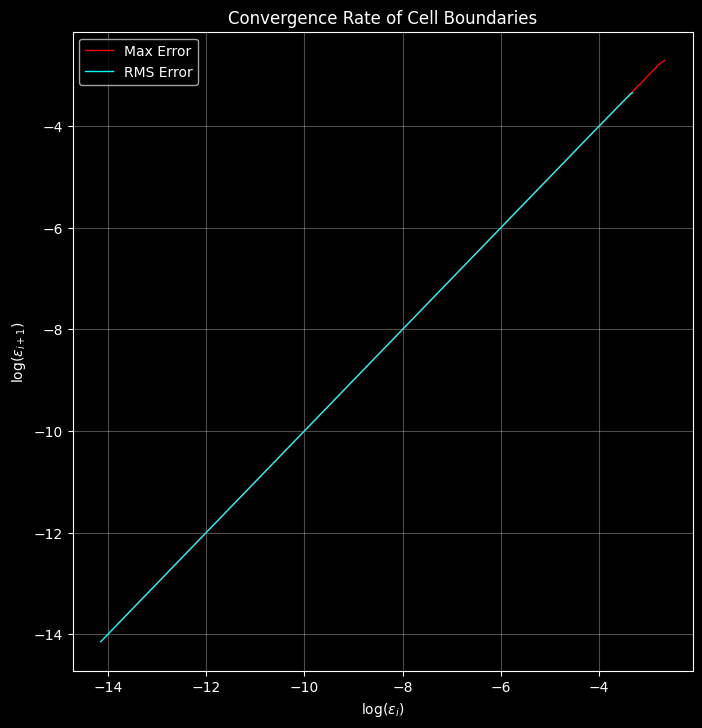

In [9]:
from plot_utils import plot_log_errors

slope, intercept = np.polyfit(np.log(rms_errors[:-1]), np.log(rms_errors[1:]), 1)
print(f"Observed order of convergence q ≈ {round(slope, 5)}")

plot_log_errors(min_errors, max_errors, rms_errors)

min: 0.9993145649
max: 0.9993148626
rms: 0.9993147652


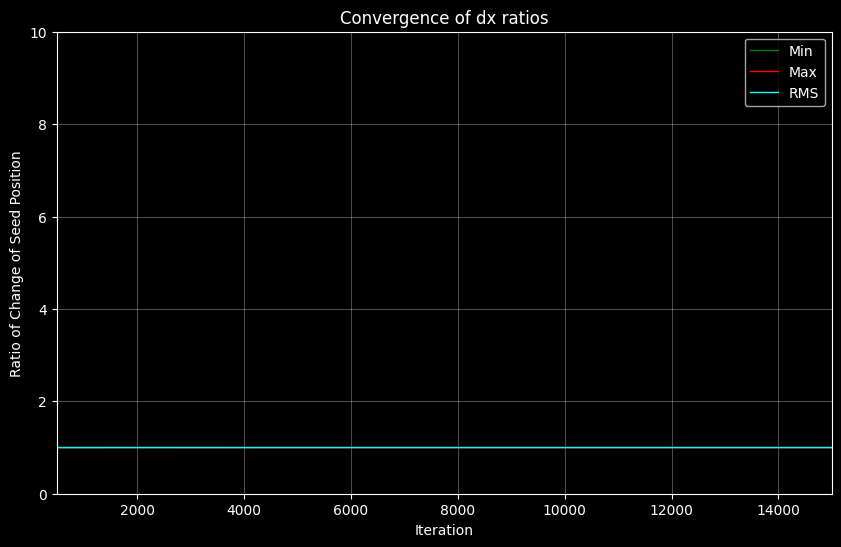

In [10]:
# Compute first derivative of the seed positions over iterations (dx/di = dx)
dx = np.diff(mesh.seed_matrix, axis=0)

# Compute ratios of successive changes in seed positions
ratios = dx[1:, :] / dx[:-1, :]
# ratios = np.abs(dx[1:, :] / dx[:-1, :])

# Plot the min, max, and RMS of the ratios over iterations
min_ratios = np.min(ratios, axis=1)
max_ratios = np.max(ratios, axis=1)
rms_ratios = np.sqrt(np.mean(ratios**2, axis=1))

# Print min, max, and RMS of the ratios after 400 iterations
n = 9000
print(f"min: {np.min(ratios[n, :]):.10f}")
print(f"max: {np.max(ratios[n, :]):.10f}")
print(f"rms: {np.sqrt(np.mean(ratios[n, :]**2)):.10f}")

display_plots([
    {"args": (min_ratios, ), "kwargs": {"label": "Min", "linewidth": 1, "color": "green"}},
    {"args": (max_ratios, ), "kwargs": {"label": "Max", "linewidth": 1, "color": "red"}},
    {"args": (rms_ratios, ), "kwargs": {"label": "RMS", "linewidth": 1, "color": "cyan"}},
], "Convergence of dx ratios", "Iteration", "Ratio of Change of Seed Position", xlims=(500, n_iters), ylims=(0, 10))

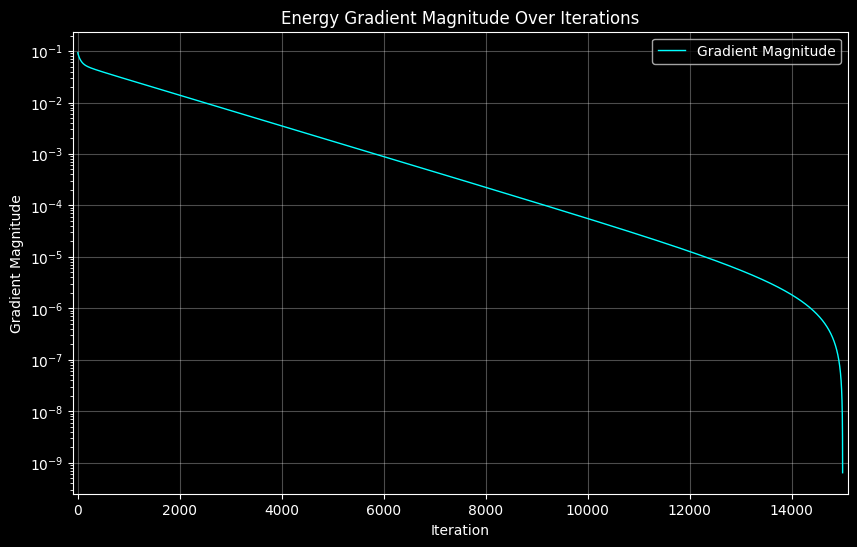

In [11]:
# Compute the energy gradient magnitudes at each iteration
# grad_mags = np.linalg.norm(mesh.energy_gradient(np.arange(n_iters)), axis=1) # type: ignore
grad_mags = np.linalg.norm(mesh.energy_gradient_2(np.arange(n_iters)), axis=1) # type: ignore

# Plot the energy gradient magnitudes
display_plots([
    {"args": (grad_mags, ), "kwargs": {"label": "Gradient Magnitude", "linewidth": 1, "color": "cyan"}},
], "Energy Gradient Magnitude Over Iterations", "Iteration", "Gradient Magnitude", xlims=(-100, n_iters+100), ylog=True)